In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
!ls

drive  sample_data


In [ ]:
import os
os.chdir('drive/MyDrive/BDPP_Data') 

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
ver_spark = "spark-3.2.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/BDPP_Data/spark-3.2.1-bin-hadoop3.2"
os.environ["PYTHONPATH"] =  os.environ["SPARK_HOME"] +'/python;' +os.environ["SPARK_HOME"]+'/python/lib/py4j-0.10.9-src.zip;' + os.environ["PYTHONPATH"] 
os.environ["PATH"] =   os.environ["SPARK_HOME"] +'/bin;' + os.environ["SPARK_HOME"] +'/python;' + os.environ["PATH"]
os.environ['PYSPARK_DRIVER_PYTHON']='jupyter'
os.environ['PYSPARK_PYTHON']='python'

In [ ]:
!pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
import re
import sys
from pyspark.rdd import RDD
from pyspark.sql import SparkSession

import timeit, time
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("DT")
sc = SparkContext(conf=conf) 
sc 

<SparkContext master=local[*] appName=DT>

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
#sc= SparkContext()
sqlContext = SQLContext(sc)
house_df = sqlContext.read.format('csv').options(header='true', inferschema='true').load('boston_house.csv')
house_df.take(1)

/content/drive/MyDrive/BDPP_Data/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


[Row(crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, b=396.9, lstat=4.98, medv=24.0)]

In [ ]:
house_df.cache()
house_df.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [ ]:
house_df.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351787,0.7026171434153232,3.561,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265
rad,506,9.549407114624506,8.707259384239366,1,24


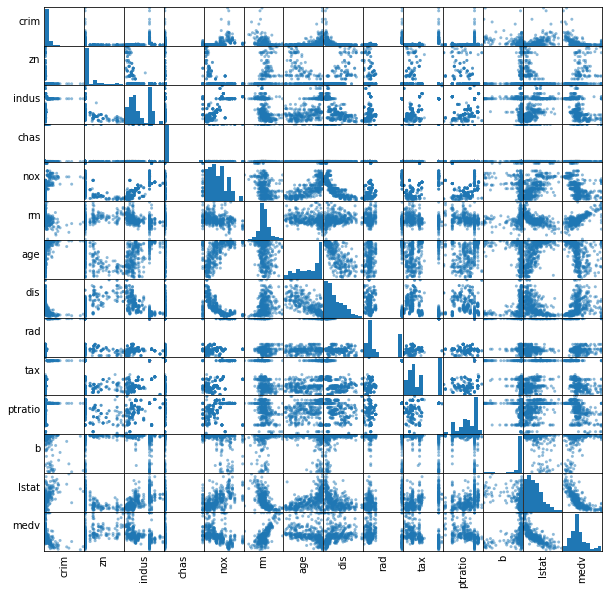

In [ ]:
import pandas as pd
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [ ]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to medv for ", i, house_df.stat.corr('medv',i))


Correlation to medv for  crim -0.38830460858681154
Correlation to medv for  zn 0.3604453424505433
Correlation to medv for  indus -0.4837251600283728
Correlation to medv for  chas 0.1752601771902987
Correlation to medv for  nox -0.4273207723732821
Correlation to medv for  rm 0.6953599470715401
Correlation to medv for  age -0.3769545650045961
Correlation to medv for  dis 0.249928734085904
Correlation to medv for  rad -0.38162623063977735
Correlation to medv for  tax -0.46853593356776674
Correlation to medv for  ptratio -0.5077866855375622
Correlation to medv for  b 0.3334608196570661
Correlation to medv for  lstat -0.7376627261740145
Correlation to medv for  medv 1.0


In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3, truncate=False)


+-------------------------------------------------------------------------+----+
|features                                                                 |medv|
+-------------------------------------------------------------------------+----+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98]  |24.0|
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14] |21.6|
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03]|34.7|
+-------------------------------------------------------------------------+----+
only showing top 3 rows



In [ ]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.009875091489246953,0.00022737947306539642,-0.0021050057541183178,1.0786823428962053,-5.337202340742156,5.417548114037861,-0.0034787897952341675,-0.5492883459307434,0.0,-0.0029819962064208234,-0.9116568300562388,0.007701594767389583,-0.4182667922273661]
Intercept: 14.490567419472749


In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)


RMSE: 4.756998
r2: 0.752718


In [ ]:
train_df.describe().show()


+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               335|
|   mean|23.249552238805975|
| stddev| 9.580440627303155|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [ ]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.820961957164762|35.4|[0.01311,90.0,1.2...|
|31.659760599407967|31.1|[0.02187,60.0,2.9...|
|27.133977391947123|16.5|[0.02498,0.0,1.89...|
| 27.74789060130063|23.9|[0.02543,55.0,3.7...|
|26.430302339826277|26.6|[0.02899,40.0,1.2...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.570753


In [ ]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.38473


In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5, 0.4294880922821315, 0.21469426500365135, 0.19110339423462275, 0.16066413148081682, 0.15874258644518874, 0.15809442930640427, 0.15753884302976903, 0.15721980917848302, 0.15703504514001976, 0.15702948925103732]


/content/drive/MyDrive/BDPP_Data/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+
|           residuals|
+--------------------+
|  -6.908066798014971|
|  0.5584224764182864|
|  -6.011396365957879|
|-0.39355433040850585|
|   2.644980305305939|
|  10.389696509904546|
| 0.22640988568414144|
| -1.6105216357387064|
| -3.1138635178502128|
|   8.213358139657473|
|   8.365114931954096|
|   3.095952834192204|
|  1.7385597649715265|
| -2.6241767566747782|
|   5.455519351818136|
| -0.9110470147990029|
|   9.378203908615028|
| -0.9675918861737571|
|   4.976057935130498|
|  2.3529057176205797|
+--------------------+
only showing top 20 rows



DECISION TREE

In [34]:
df = sqlContext.read.format('csv').options(header='true', inferschema='true').load('bank.csv')
house_df.take(1)

[Row(crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, b=396.9, lstat=4.98, medv=24.0)]

In [35]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [36]:
import pandas as pd
df.groupBy('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [37]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
print(numeric_features)
df.select(numeric_features).describe().toPandas().transpose()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


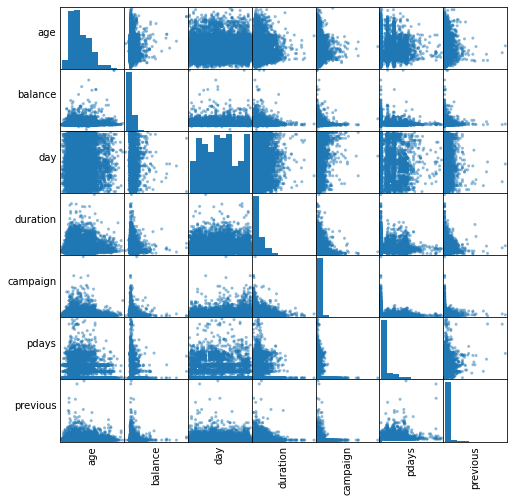

In [38]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [39]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [40]:
from pyspark.ml.feature import OneHotEncoder,StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
print(assemblerInputs)
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
print(stages)

['jobclassVec', 'maritalclassVec', 'educationclassVec', 'defaultclassVec', 'housingclassVec', 'loanclassVec', 'contactclassVec', 'poutcomeclassVec', 'age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
[StringIndexer_652463540698, OneHotEncoder_2ce562011b7c, StringIndexer_478740f9b10b, OneHotEncoder_532d8d8c07ab, StringIndexer_2bcadb041839, OneHotEncoder_a3c294e8339d, StringIndexer_f58c201e9e70, OneHotEncoder_302c078808fe, StringIndexer_c1b0ef79aad6, OneHotEncoder_4331eb68cfa7, StringIndexer_9483f8a2958d, OneHotEncoder_9fa13b5c9101, StringIndexer_ff0fe84f6829, OneHotEncoder_ba44c08ecf1d, StringIndexer_1d9c96f8b93e, OneHotEncoder_048ab29e38bf, StringIndexer_6e5e1d71dd6b, VectorAssembler_974259bb703e]


In [41]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [42]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()


,0,1,2,3,4
label,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [43]:
train, test = df.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
train.groupBy('deposit').count()
test.groupBy('deposit').count()

Training Dataset Count: 7707
Test Dataset Count: 3455


DataFrame[deposit: string, count: bigint]

In [44]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [45]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

/content/drive/MyDrive/BDPP_Data/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


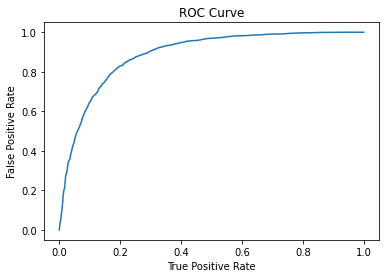

Training set areaUnderROC: 0.8875603573210151


In [47]:
import matplotlib.pyplot as plt
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/content/drive/MyDrive/BDPP_Data/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


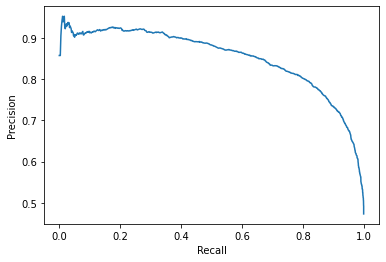

In [48]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [49]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.84878396482821...|       0.0|[0.86398426330407...|
| 37|management|  0.0|[1.06724282124965...|       0.0|[0.74407222314955...|
| 61|management|  0.0|[0.60789557816809...|       0.0|[0.64746060568868...|
| 67|management|  0.0|[-1.1432249818701...|       1.0|[0.24172874259806...|
| 57|management|  0.0|[0.90407864807785...|       0.0|[0.71178694437212...|
| 46|management|  0.0|[0.04736344601300...|       0.0|[0.51183864845324...|
| 50|management|  0.0|[-2.6699662391562...|       1.0|[0.06476901360569...|
| 50|management|  0.0|[-1.2992882839640...|       1.0|[0.21428482196810...|
| 58|management|  0.0|[-2.8699707222870...|       1.0|[0.05365813867905...|
| 40|management|  0.0|[2.86893224769426...|       0.0|[0.94628910423001...|
+---+-------

In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8855828929742716


In [51]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2440.0,490.0]|       0.0|[0.83276450511945...|
| 37|management|  0.0|[2440.0,490.0]|       0.0|[0.83276450511945...|
| 61|management|  0.0|[2440.0,490.0]|       0.0|[0.83276450511945...|
| 67|management|  0.0|[417.0,1749.0]|       1.0|[0.19252077562326...|
| 57|management|  0.0|[2440.0,490.0]|       0.0|[0.83276450511945...|
| 46|management|  0.0|[417.0,1749.0]|       1.0|[0.19252077562326...|
| 50|management|  0.0|[417.0,1749.0]|       1.0|[0.19252077562326...|
| 50|management|  0.0|[781.0,1221.0]|       1.0|[0.39010989010989...|
| 58|management|  0.0|[781.0,1221.0]|       1.0|[0.39010989010989...|
| 40|management|  0.0|[2440.0,490.0]|       0.0|[0.83276450511945...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [52]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.775052601242276


In [53]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[14.8668794826790...|       0.0|[0.74334397413395...|
| 37|management|  0.0|[14.1040631129179...|       0.0|[0.70520315564589...|
| 61|management|  0.0|[9.29860654857896...|       1.0|[0.46493032742894...|
| 67|management|  0.0|[5.38361284119075...|       1.0|[0.26918064205953...|
| 57|management|  0.0|[14.4255182162771...|       0.0|[0.72127591081385...|
| 46|management|  0.0|[12.5694055739868...|       0.0|[0.62847027869934...|
| 50|management|  0.0|[7.06904399387855...|       1.0|[0.35345219969392...|
| 50|management|  0.0|[4.82922012718091...|       1.0|[0.24146100635904...|
| 58|management|  0.0|[3.83096570214734...|       1.0|[0.19154828510736...|
| 40|management|  0.0|[16.5845419742580...|       0.0|[0.82922709871290...|
+---+-------

In [54]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8820867241988563
